In [26]:
package_names.vec<- c("glue","tidyverse","geomtextpath","ggrepel","ggridges","patchwork","ggpattern","waffle","ggtext","showtext","tidymodels","broom","ranger","knitr","webshot")
package_prep <- \(names.vec)
{
  for (name in names.vec)
  {
    if ( !require(name,character.only = TRUE)) renv::install(name)
  }
}
package_names.vec |> package_prep()


In [29]:
install.packages("kabelExtra")

Traceback (most recent calls last):
24: install.packages("kabelExtra")
23: eval(call, envir = parent.frame())
22: eval(call, envir = parent.frame())
21: renv::install("kabelExtra")
20: renv_retrieve_impl(packages)
19: handler(package, renv_retrieve_impl_one(package))
18: renv_retrieve_impl_one(package)
17: withCallingHandlers(renv_available_packages_latest(package), 
        error = function(err) stopf("package '%s' is not available", 
            package))
16: renv_available_packages_latest(package)
15: map(errors$data(), warning)
14: lapply(x, f, ...)
13: FUN(X[[i]], ...)
12: withRestarts({
        .Internal(.signalCondition(cond, message, call))
        .Internal(.dfltWarn(message, call))
    }, muffleWarning = function() NULL)
11: withOneRestart(expr, restarts[[1L]])
10: doWithOneRestart(return(expr), restart)
 9: <condition-handler>(...)
 8: stopf("package '%s' is not available", package)
 7: stop(sprintf(fmt, ...), call. = call.)
 6: .handleSimpleError(function (cnd) 
    {
     

: [1m[33mError[39m:[22m
[33m![39m package 'kabelExtra' is not available

In [2]:
if (!"package:tidyverse" %in% search()) library(tidyverse)
if (!file.exists('intermediate-data')) dir.create('intermediate-data')
list.files(
  file.path('data'),
  pattern = "\\.zip$",
  full.names = T
  ) |> 
  walk(~unzip(.x,exdir = file.path('intermediate-data')))



In [3]:
#if (!"package:tidyverse" %in% search()) library(tidyverse)
if (!"package:readxl" %in% search()) library(readxl)
load_tbl <- function(name,path,argyear,reading_func){
  result <- file.path(path) |> 
    reading_func() |> 
    mutate(
      year = argyear,
      ID = row_number()
    ) |> 
    select(where(~!all(is.na(.x))))
  assign(name,result,envir = .GlobalEnv)
}
load_tbl("gfi_2021.tbl",
  file.path(
    "intermediate-data",
    "micro_irn.csv"),
  2021,
  read_csv
)
load_tbl("gfi_2017_1.tbl",
  file.path(
    "intermediate-data",
    "IRN_2017_FINDEX_v02_M_EXCEL",
    "micro_irn_varlabel.xls"),
  2017,
  read_excel
)
load_tbl("gfi_2017_2.tbl",
  file.path("intermediate-data",
    "IRN_2017_FINDEX_v02_M_EXCEL",
    "micro_irn_varname.xls"),
  2017,
  read_excel
)

Rows: 1005 Columns: 84
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr  (2): economy, economycode
dbl (78): wpid_random, wgt, female, age, educ, inc_q, emp_in, account, accou...
lgl  (4): urbanicity_f2f, receive_agriculture, remittances, merchantpay_dig

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


In [4]:
new_names <- gsub("[ :-]","_",gfi_2017_1.tbl |> names())
new_names2 <- gsub("_+","_",new_names)
gfi_2017_renamed.tbl <- gfi_2017_1.tbl |> rename(
  !!!setNames(
    names(gfi_2017_1.tbl),
    new_names2
  )
)

In [5]:
core_controls <- c(
  "year",
  "ID",
  "Weight",
  "Respondent_is_female",
  "Respondent_age",
  "Respondent_education_level",
  "Respondent_is_in_the_workforce",
  "Within_economy_household_income_quintile",
  "Main_source_of_emergency_funds",
  "Payments_utility_bills",
  "Has_an_account",
  "Has_an_account_at_a_financial_institution",
  "Has_a_mobile_money_account"
)
control_cols2017 <- c(
  core_controls,
  "Payments_wage_payments",
  "Payments_government_transfers",
  "Payments_government_pension"
)
control_cols2021 <- c(
  core_controls,
  "Difficulty_of_emergency_funds_in_30_days",
  "Received_a_government_pension_payment",
  "Received_a_government_transfer_payment",
  "Financially_most_worried",
  "Financially_worried_education",
  "Financially_worried_bills",
  "Financially_worried_medical_cost",
  "Financially_worried_old_age",
  "Difficulty_of_emergency_funds_in_7_days",
  "Paid_a_utility_bill",
  "Received_a_government_pension",
  "Received_a_wage_payment"
)

In [6]:
long_gfi_2017.tbl <- gfi_2017_renamed.tbl |> 
  select(-c(Economy,Economy_Code,Gallup_World_Poll_identifier)) |> 
  mutate(
    Respondent_education_level = case_match(
      Respondent_education_level,
      c("(dk)","(rf)") ~ NA,
      .default = Respondent_education_level
    ),
    Main_source_of_emergency_funds = case_match(
      Main_source_of_emergency_funds,
      c("(dk)","ref") ~ NA,
      .default = Main_source_of_emergency_funds
    )
  ) |> 
  pivot_longer(
    cols = -c(!!!syms(control_cols2017)),
    names_to = "Question",
    values_to = "Answers"
    ) |> 
  mutate(
    Answers = case_match(
      Answers,
      c("yes","Yes","Possible") ~ "1",
      c("no","No","Not possible") ~ "2",
      c("(DK)","(dk)") ~ "3",
      c("(ref)","ref","(Refused)") ~ "4",
      .default = as.character(Answers)
      )
    )  |> 
  mutate(Answers = fct(Answers)) |> 
  group_by(ID) |> 
  mutate(Question_no = row_number()) |> 
  ungroup() |> 
  mutate(
    across(
      -c(
        Respondent_age,
        Weight,
        Question_no,
        ID
      ),
      ~as_factor(.x)
    )
  ) |>
  mutate(
    Respondent_age = case_when(
      is.na(Respondent_age) ~ NA,
      Respondent_age == "99+" ~ 100,
      .default = as.integer(Respondent_age)
    ),
    Has_an_account_at_a_financial_institution = case_match(
      Has_an_account_at_a_financial_institution,
      "yes" ~ "Yes",
      "0" ~ "No",
      .default = Has_an_account_at_a_financial_institution
    ),
    Has_an_account = case_match(
      Has_an_account,
      "yes" ~ "Yes",
      "0" ~ "No",
      .default = Has_an_account
    ),
    Has_a_mobile_money_account = case_match(
      Has_a_mobile_money_account,
      "yes" ~ "Yes",
      "0" ~ "No",
      .default = Has_a_mobile_money_account
    )
  )


Warning message:
There was 1 warning in `mutate()`.
ℹ In argument: `Respondent_age = case_when(...)`.
Caused by warning in `vec_case_when()`:
! NAs introduced by coercion 


In [7]:
# Define the named vector with keys in double quotes (replaced to become similar with 2017 column names.)
names_dict_2021 <- c(
  "saved" = "Saved_in_the_past_year",
"borrowed" = "Borrowed_in_the_past_year",
"receive_wages" = "Received_a_wage_payment",
"receive_transfers" = "Received_a_government_transfer_payment",
"receive_pension" = "Received_a_government_pension_payment",
"pay_utilities" = "Payments_utility_bills",
"mobileowner" = "Owns_a_mobile_phone",
"internetaccess" = "Internet_access",
"anydigpayment" = "Made_or_received_a_digital_payment",
"fin34a" = "Received_wage_payments_into_an_account",
"fin34b" = "Received_wage_payments_to_a_mobile_phone",
"fin34d" = "Received_wage_payments_in_cash",
"fin34e" = "Received_wage_payments_to_a_card",
"fin37" = "Payments_government_transfers",
"fin38" = "Received_a_government_pension",
"fin39a" = "Received_a_government_transfer_or_pension_into_an_account",
"fin39b" = "Received_a_government_transfer_or_pension_to_a_mobile_phone",
"fin39d" = "Received_a_government_transfer_or_pension_in_cash",
"fin39e" = "Received_a_government_transfer_or_pension_to_a_card",
"fin44a" = "Financially_worried_old_age",
"fin44b" = "Financially_worried_medical_cost",
"fin44c" = "Financially_worried_bills",
"fin44d" = "Financially_worried_education",
"fin45" = "Financially_most_worried",
"fin16" = "Saved_for_old_age",
"fin17a" = "Saved_using_an_account_at_a_financial_institution",
"fin17a1" = "Saved_using_a_mobile_money_account",
"fin20" = "Borrowed_for_medical_purposes",
"fin22a" = "Borrowed_from_a_financial_institution",
"fin22b" = "Borrowed_from_family_or_friends",
"fin24" = "Main_source_of_emergency_funds",
"fin24a" = "Difficulty_of_emergency_funds_in_30_days",
"fin24b" = "Difficulty_of_emergency_funds_in_7_days",
"fin30" = "Paid_a_utility_bill",
"fin31a" = "Paid_a_utility_bill_using_an_account",
"fin31b" = "Paid_a_utility_bill_using_a_mobile_phone",
"fin31c" = "Paid_a_utility_bill_in_cash",
"fin32" = "Payments_wage_payments",
"fin33" = "Received_public_sector_wage_payments",
"fin11b" = "Reason_for_no_account_too_expensive",
"fin11c" = "Reason_for_no_account_lack_documentation",
"fin11d" = "Reason_for_no_account_lack_trust",
"fin11e" = "Reason_for_no_account_religious_reasons",
"fin11f" = "Reason_for_no_account_lack_money",
"fin11g" = "Reason_for_no_account_family_member_already_has_one",
"fin11h" = "Reason_for_no_account_no_need_for_financial_services",
"fin13a" = "Use_mobile_money_account_two_or_more_times_a_month",
"fin13b" = "Use_mobile_money_account_to_store_money",
"fin13c" = "Use_mobile_money_account_to_borrow_money",
"fin13d" = "Use_mobile_money_account_without_help",
"fin14_1" = "Use_mobile_phone_to_pay_for_a_purchase_in_store",
"fin14a" = "Made_bill_payments_online_using_the_Internet",
"fin14a1" = "Send_money_to_a_relative_or_friend_online_using_the_Internet",
"fin14b" = "Bought_something_online_using_the_Internet",
"account_mob" = "Has_a_mobile_money_account",
"fin2" = "Has_a_debit_card",
"fin4" = "Used_a_debit_card",
"fin5" = "Used_a_mobile_phone_or_internet_to_access_account",
"fin6" = "Used_a_mobile_phone_or_internet_to_check_account_balance",
"fin7" = "Has_a_credit_card",
"fin8" = "Used_a_credit_card",
"fin8b" = "Paid_credit_card_balances_in_full",
"fin9" = "Made_any_deposit_into_the_account",
"fin9a" = "Make_deposits_into_the_account_two_or_more_times_per_month",
"fin10" = "Withdrew_from_the_account",
"fin10a" = "Withdrew_from_the_account_two_or_more_times_per_month",
"fin10b" = "Used_account_to_store_money",
"fin11_1" = "Unbanked_use_account_without_help",
"fin11a" = "Reason_for_no_account_too_far",
"economy" = "Economy",
"economycode" = "Economy_Code",
"wpid_random" = "Gallup_World_Poll_identifier",
"wgt" = "Weight",
"female" = "Respondent_is_female",
"age" = "Respondent_age",
"educ" = "Respondent_education_level",
"inc_q" = "Within_economy_household_income_quintile",
"emp_in" = "Respondent_is_in_the_workforce",
"account" = "Has_an_account",
"account_fin" = "Has_an_account_at_a_financial_institution",
"year" = "year",
"ID" = "ID"
)

In [8]:
long_gfi_2021.tbl <- gfi_2021.tbl |> rename(
  !!!setNames(
    names(gfi_2021.tbl),
    names_dict_2021[names(gfi_2021.tbl)]
  )
)|> 
  select(-c(Economy,Economy_Code,Gallup_World_Poll_identifier)) |> 
  pivot_longer(
    cols= -c(
      !!!syms(control_cols2021)
    ),
    names_to = "Question",
    values_to = "Answers"
  ) |> mutate(
    Respondent_is_female = case_match(
      Respondent_is_female,
      1 ~ "Female",
      2 ~ "Male",
      .default = NA
    ),
    Respondent_education_level = case_match(
      Respondent_education_level,
      1 ~ "completed primary or less",
      2 ~ "secondary",
      3 ~ "completed tertiary or more",
      .default = NA
      ),
    Respondent_is_in_the_workforce = case_match(
      Respondent_is_in_the_workforce,
      1 ~ "in workforce",
      2 ~ "out of workforce",
      .default = NA
    ),
    Within_economy_household_income_quintile = case_match(
      Within_economy_household_income_quintile,
      1 ~ "Poorest 20%",
      2 ~ "Second 20%",
      3 ~ "Middle 20%",
      4 ~ "Fourth 20%",
      5 ~ "Richest 20%",
      .default = NA
    ),
    Has_an_account_at_a_financial_institution = case_match(
      Has_an_account_at_a_financial_institution,
      1 ~ "Yes",
      0 ~ "No",
      .default = NA
    ),
    Has_an_account = case_match(
      Has_an_account,
      1 ~ "Yes",
      0 ~ "No",
      .default = NA
    ),
    Has_a_mobile_money_account = case_match(
      Has_a_mobile_money_account,
      1 ~ "Yes",
      0 ~ "No",
      .default = NA
    )
  ) |> 
    group_by(ID) |> 
    mutate(Question_no= row_number()) |> 
    ungroup() |> 
    mutate(
      across(-c(ID,Respondent_age,Weight,Question_no), ~as_factor(.x))
    )

In [9]:
combined.tbl <- bind_rows(
  long_gfi_2017.tbl,
  long_gfi_2021.tbl
)
weighted_sum <- combined.tbl |> 
  select(-c(Question,Answers,Question_no,ID)) |> 
  mutate(weighted_s = Weight/sum(Weight)) |> 
  slice_sample(n = 1e6,weight_by = weighted_s,replace = TRUE)

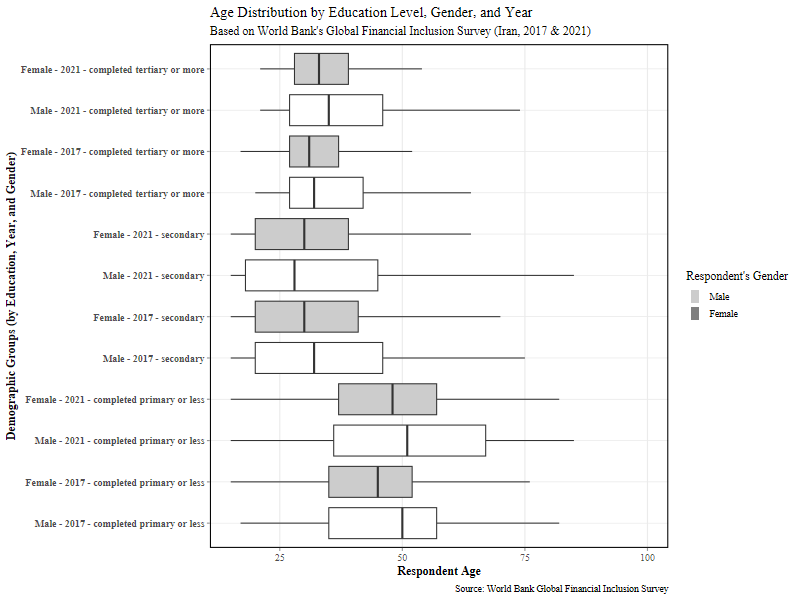

In [10]:
weighted_sum |> 
  select(Respondent_age, Respondent_education_level, Respondent_is_female, year) |> 
  filter(!is.na(Respondent_education_level)) |> 
  group_by(year) |> 
  mutate(avg_age = mean(Respondent_age,na.rm=TRUE)) |> 
  ungroup() |> 
  mutate(
    year = fct_relevel(year,"2017","2021"),
    Respondent_is_female = fct_relevel(Respondent_is_female,"Male","Female"),
    Respondent_education_level = fct_relevel(Respondent_education_level,"completed primary or less","secondary","completed tertiary or more")
  ) |> 
  ggplot(aes(y = interaction(Respondent_is_female,year,Respondent_education_level, sep = " - "), 
             x = Respondent_age, fill = Respondent_is_female)) +
  geom_boxplot(size = 0.5, width = 0.75, outlier.shape = NA) + # Adjusting boxplot line weight and width
  scale_fill_grey(start = 1, end = 0.8, name = "Respondent's Gender", labels = c("Male", "Female")) +
    guides(fill = guide_legend(
      override.aes = list(shape = 22, size = 5, fill = c("grey80", "grey50"), color = "black", linetype = 0)
    )) + # Custom legend with plain squares
  labs(
    title = "Age Distribution by Education Level, Gender, and Year",
    subtitle = "Based on World Bank's Global Financial Inclusion Survey (Iran, 2017 & 2021)",
    y = "Demographic Groups (by Education, Year, and Gender)",
    x = "Respondent Age",
    fill = "Gender",
    caption = "Source: World Bank Global Financial Inclusion Survey"
  ) +
  theme_minimal(base_size = 12) +
  theme(
    legend.position = "right",
    axis.title.y = element_text(face = "bold"),
    axis.title.x = element_text(face = "bold"),
    axis.text.y = element_text(face = "bold"),
    panel.grid.major.y = element_line(color = "gray90", linewidth = 0.3), # Subtle horizontal gridlines
    panel.grid.minor = element_blank(), # Removing minor gridlines
    axis.ticks = element_line(color = "gray60"), # Subtle axis ticks
    axis.text = element_text(size = 10), # Adjusting axis text size
    text = element_text(family = "Times New Roman"), # Clean font style
    panel.border = element_rect(color = "black",fill = NA,linewidth = 1)
  )




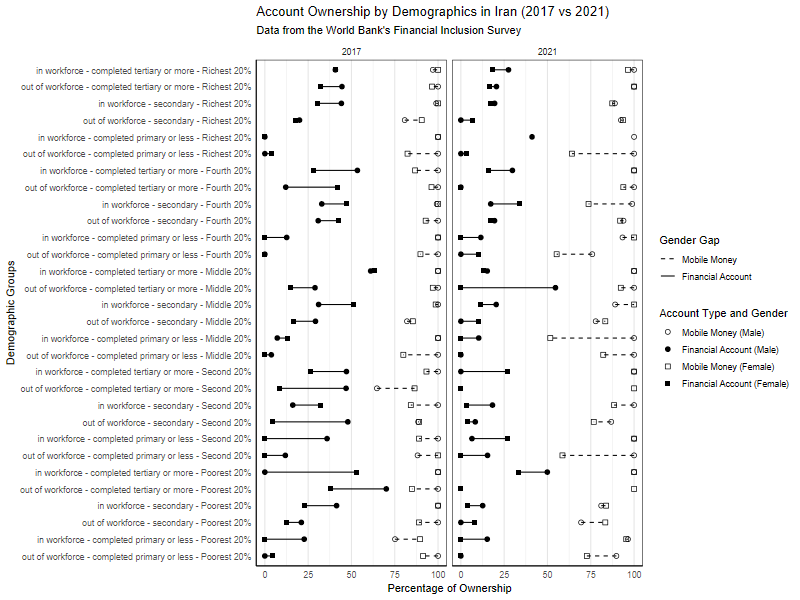

In [11]:
plot_data <- weighted_sum |> 
  select(
    Respondent_education_level,
    Respondent_is_in_the_workforce,
    Within_economy_household_income_quintile,
    Has_a_mobile_money_account,
    Has_an_account_at_a_financial_institution,
    year,
    Respondent_is_female
  ) |> 
  mutate(
    Respondent_education_level = fct_relevel(Respondent_education_level,"completed primary or less","secondary","completed tertiary or more"),
    Respondent_is_in_the_workforce = fct_relevel(Respondent_is_in_the_workforce,"out of workforce","in workforce"),
    Within_economy_household_income_quintile = fct_relevel(Within_economy_household_income_quintile,"Poorest 20%","Second 20%","Middle 20%","Fourth 20%","Richest 20%"),
    category_combination = interaction(
      Respondent_is_in_the_workforce,
      Respondent_education_level,
      Within_economy_household_income_quintile,
      sep = " - "
  )) |> 
  # Filter out rows with NA values
  filter(
    !is.na(Has_a_mobile_money_account),
    !is.na(Has_an_account_at_a_financial_institution),
    !is.na(category_combination)
  )  |> 
  # Group by year, category combination, and gender
  group_by(year, category_combination, Respondent_is_female)  |> 
  summarise(
    mobile_money_yes_pct = mean(Has_a_mobile_money_account == "Yes", na.rm = TRUE) * 100,
    financial_account_yes_pct = mean(Has_an_account_at_a_financial_institution == "Yes", na.rm = TRUE) * 100,
    .groups = "drop"
  )  |> 
  pivot_longer(
    cols = c(mobile_money_yes_pct, financial_account_yes_pct),
    names_to = "account_type",
    values_to = "yes_pct"
  )

# Separate Male and Female data for connector lines
male_data <- plot_data  |>  filter(Respondent_is_female == "Male")
female_data <- plot_data  |>  filter(Respondent_is_female == "Female")

# Merge Male and Female data for segment lines
connector_data <- male_data  |> 
  rename(yes_pct_male = yes_pct)  |> 
  inner_join(female_data  |>  rename(yes_pct_female = yes_pct),
             by = c("year", "category_combination", "account_type"))
 
 
 
ggplot(plot_data, aes(x = category_combination, y = yes_pct)) +
  # Connector lines (solid for mobile money, dashed for financial account)
  geom_segment(data = connector_data,
               aes(
                 x = category_combination,
                 xend = category_combination,
                 y = yes_pct_male,
                 yend = yes_pct_female,
                 linetype = account_type
               ),
               color = "black") +
  # Add male and female dots with distinct shapes
  geom_point(
    aes(
      shape = interaction(account_type, Respondent_is_female)
    ),
    size = 2,  # Smaller points
    color = "black"
  ) +
  # Separate charts by year
  facet_wrap(~year, nrow = 1) +
  # Flip coordinates for horizontal chart
  coord_flip() +
  # Adjust theme to remove horizontal gridlines only
  theme_minimal() +
  theme(
    panel.grid.major.y = element_blank(),  # Remove horizontal gridlines after flipping
    panel.grid.major.x = element_line(color = "gray90"),  # Retain vertical gridlines
    axis.line = element_line(color = "black"),
    panel.border = element_rect(color = "black", fill = NA)  # Add borders
  ) +
  # Custom linetype and shape legend with improved labels
  scale_linetype_manual(
    values = c(
      "mobile_money_yes_pct" = "solid",
      "financial_account_yes_pct" = "dashed"
    ),
    labels = c("Mobile Money", "Financial Account")
  ) +
  scale_shape_manual(
    values = c(
      "mobile_money_yes_pct.Male" = 19,
      "financial_account_yes_pct.Male" = 1,
      "mobile_money_yes_pct.Female" = 15,
      "financial_account_yes_pct.Female" = 0
    ),
    labels = c(
      "Mobile Money (Male)",
      "Financial Account (Male)",
      "Mobile Money (Female)",
      "Financial Account (Female)"
    )
  ) +
  labs(
    title = "Account Ownership by Demographics in Iran (2017 vs 2021)",
    subtitle = "Data from the World Bank's Financial Inclusion Survey",
    x = "Demographic Groups",
    y = "Percentage of Ownership",
    shape = "Account Type and Gender",
    linetype = "Gender Gap"
  )


Warning message:
Using `size` aesthetic for lines was deprecated in ggplot2 3.4.0.
ℹ Please use `linewidth` instead.
This warning is displayed once every 8 hours.
Call `lifecycle::last_lifecycle_warnings()` to see where this warning was
generated. 


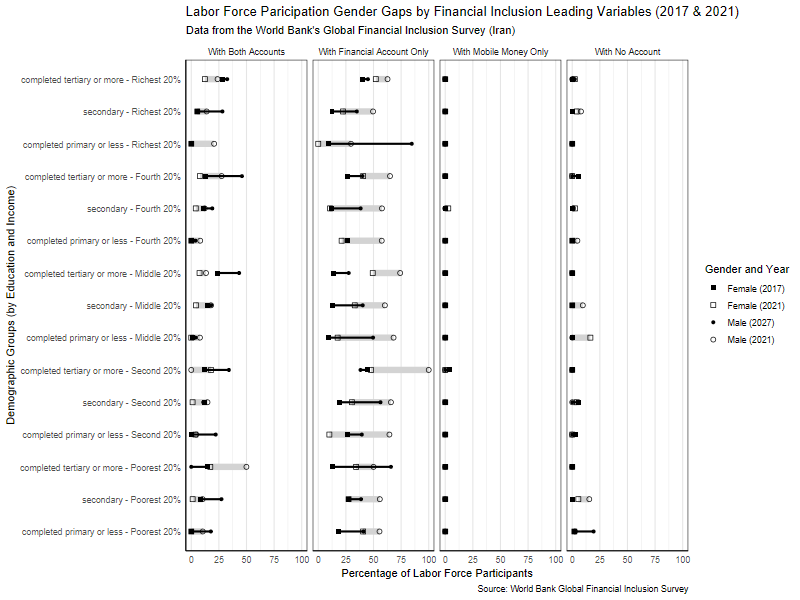

In [12]:
# First, include 'neither_accounts_pct' in your summarization
plot_data <- weighted_sum |> 
  select(
    Respondent_education_level,
    Has_an_account_at_a_financial_institution,
    Has_a_mobile_money_account,
    Within_economy_household_income_quintile,
    Respondent_is_in_the_workforce,
    year,
    Respondent_is_female
  ) |> 
  mutate(
    Respondent_education_level = fct_relevel(Respondent_education_level,"completed primary or less","secondary","completed tertiary or more"),
    Within_economy_household_income_quintile = fct_relevel(Within_economy_household_income_quintile,"Poorest 20%","Second 20%","Middle 20%","Fourth 20%","Richest 20%"),
    Respondent_is_female = fct_relevel(Respondent_is_female,"Male","Female"),
    year = fct_relevel(year,"2017","2021"),
    category_combination = interaction(
      Respondent_education_level,
      Within_economy_household_income_quintile,
      sep = " - "
  )) |> 
  # Filter out rows with NA values
  filter(
    !is.na(Has_an_account_at_a_financial_institution),
    !is.na(Has_a_mobile_money_account),
    !is.na(category_combination)
  ) |> 
  # Group by year, category combination, and gender
  group_by(year, category_combination, Respondent_is_female) |> 
  summarise(
    mobile_money_only_pct = mean(
      Respondent_is_in_the_workforce == "in workforce" & 
      Has_a_mobile_money_account == "Yes" & 
      Has_an_account_at_a_financial_institution == "No", 
      na.rm = TRUE
    ) * 100,
    financial_account_only_pct = mean(
      Respondent_is_in_the_workforce == "in workforce" & 
      Has_a_mobile_money_account == "No" & 
      Has_an_account_at_a_financial_institution == "Yes", 
      na.rm = TRUE
    ) * 100,
    both_accounts_pct = mean(
      Respondent_is_in_the_workforce == "in workforce" & 
      Has_a_mobile_money_account == "Yes" & 
      Has_an_account_at_a_financial_institution == "Yes", 
      na.rm = TRUE
    ) * 100,
    neither_accounts_pct = mean(
      Respondent_is_in_the_workforce == "in workforce" & 
      Has_a_mobile_money_account == "No" & 
      Has_an_account_at_a_financial_institution == "No", 
      na.rm = TRUE
    ) * 100,
    .groups = "drop"
  ) |> 
  pivot_longer(
    cols = c(mobile_money_only_pct, financial_account_only_pct, both_accounts_pct, neither_accounts_pct),
    names_to = "participation_type",
    values_to = "yes_pct"
  ) |> 
  # Create informative labels for participation types
  mutate(
    participation_label = factor(
      participation_type,
      levels = c("both_accounts_pct", "financial_account_only_pct", "mobile_money_only_pct", "neither_accounts_pct"),
      labels = c("With Both Accounts", "With Financial Account Only", "With Mobile Money Only", "With No Account")
    ),
    gender_year = paste(Respondent_is_female, year, sep = " ")
  )

# Prepare connector data
connector_data <- plot_data |> 
  pivot_wider(
id_cols = c(year,category_combination,participation_type,participation_label),
    names_from = Respondent_is_female,
    values_from = yes_pct
  )

  ggplot(plot_data, aes(x = category_combination, y = yes_pct)) +
    # Connector lines
    geom_segment(
      data = connector_data |> filter(year == 2021),
      aes(
        x = category_combination,
        xend = category_combination,
        y = Male,
        yend = Female,
        size = factor(year),
        color = factor(year)
      ),
      show.legend = F
    ) +
      geom_segment(
        data = connector_data |> filter(year == 2017),
        aes(
          x = category_combination,
          xend = category_combination,
          y = Male,
          yend = Female,
          size = factor(year),
          color = factor(year)
        ),
        show.legend = F
      ) +
    # Data points
    geom_point(
      aes(
        shape = factor(gender_year)
      ),
      size = 2,
      color = "black"
    ) +
    # Facet by participation_label in a 1x4 grid
    facet_wrap(~ participation_label, nrow = 1) +
    # Flip coordinates for horizontal chart
    coord_flip() +
    # Adjust theme to remove horizontal gridlines only
    theme_minimal() +
    theme(
      panel.grid.major.y = element_blank(),
      panel.grid.major.x = element_line(color = "gray90"),
      axis.line = element_line(color = "black"),
      panel.border = element_rect(color = "black", fill = NA),
      legend.position = "right"
    ) +
    # Custom scales for line size and color
    scale_size_manual(
      values = c("2017" = 1, "2021" = 3),
      guide = 'none'
    ) +
    scale_color_manual(
      values = c("2017" = "black", "2021" = "lightgray"),
      guide = 'none'
    ) +
    # Custom shape legend with improved labels
    scale_shape_manual(
      values = c(
        "Male 2017" = 20,
        "Female 2017" = 15,
        "Male 2021" = 1,
        "Female 2021" = 0
      ),
      labels = c(
        "Female (2017)",
        "Female (2021)",
        "Male (2027)",
        "Male (2021)"
      )
    ) +
    # Enhanced labels and title
    labs(
      title = "Labor Force Paricipation Gender Gaps by Financial Inclusion Leading Variables (2017 & 2021)",
      subtitle = "Data from the World Bank's Global Financial Inclusion Survey (Iran)",
      x = "Demographic Groups (by Education and Income)",
      y = "Percentage of Labor Force Participants",
      shape = "Gender and Year",
      caption = "Source: World Bank Global Financial Inclusion Survey"
    )
  

In [13]:
weighted_sumw <- weighted_sum |> 
  mutate(
    inc  = factor(Within_economy_household_income_quintile, levels = c("Poorest 20%","Second 20%","Middle 20%","Fourth 20%","Richest 20%"),ordered = T),
    educ = factor(Respondent_education_level, levels = c("completed primary or less","secondary","completed tertiary or more"),ordered = T)
)
 workflow() |> 
  add_model(
    logistic_reg() |> set_engine("glm") |> set_mode("classification")
  ) |> 
  add_recipe(
    recipe(Respondent_is_in_the_workforce ~ 
      Respondent_is_female + 
      Respondent_age+
      Has_an_account_at_a_financial_institution+
      Has_a_mobile_money_account+
      inc+
      year+
      educ,
     data = weighted_sumw) |> 
      step_dummy(year) |> 
      step_ordinalscore(inc) |> 
      step_ordinalscore(educ)
  ) |> 
fit(data = weighted_sumw) |> 
   extract_fit_parsnip() |> 
   tidy()

# A tibble: 8 × 5
  term                                      estimate std.error statistic p.value
  <chr>                                        <dbl>     <dbl>     <dbl>   <dbl>
1 (Intercept)                               -0.551    0.0129       -42.7       0
2 Respondent_is_femaleFemale                -1.67     0.00462     -362.        0
3 Respondent_age                            -0.00753  0.000148     -51.0       0
4 Has_an_account_at_a_financial_institutio…  0.779    0.00882       88.3       0
5 Has_a_mobile_money_accountYes              0.499    0.00603       82.7       0
6 inc                                       -0.116    0.00168      -68.8       0
7 educ                                       0.528    0.00382      138.        0
8 year_X2021                                 0.604    0.00464      130.        0

In [30]:
wieghted_sumw <- combined.tbl  |> 
  select(-c(Question,Answers,Question_no,ID)) |>
    mutate(
      inc  = factor(Within_economy_household_income_quintile, levels = c("Poorest 20%","Second 20%","Middle 20%","Fourth 20%","Richest 20%"),ordered = T),
      educ = factor(Respondent_education_level, levels = c("completed primary or less","secondary","completed tertiary or more"),ordered = T)
  )
   workflow() |> 
    add_model(
      logistic_reg() |> set_engine("glm") |> set_mode("classification")
    ) |> 
    add_recipe(
      recipe(Respondent_is_in_the_workforce ~ 
        Respondent_is_female + 
        Respondent_age+
        Has_an_account_at_a_financial_institution+
        Has_a_mobile_money_account+
        inc+
        year+
        educ,
       data = weighted_sumw,
      weight = Weight) |> 
        step_dummy(year) |> 
        step_ordinalscore(inc) |> 
        step_ordinalscore(educ)
    ) |> 
  fit(data = weighted_sumw) |> 
     extract_fit_parsnip() |>
     tidy() |> 
     kable(format = "html",caption = "model results")

<table>
<caption>model results</caption>
 <thead>
  <tr>
   <th style="text-align:left;"> term </th>
   <th style="text-align:right;"> estimate </th>
   <th style="text-align:right;"> std.error </th>
   <th style="text-align:right;"> statistic </th>
   <th style="text-align:right;"> p.value </th>
  </tr>
 </thead>
<tbody>
  <tr>
   <td style="text-align:left;"> (Intercept) </td>
   <td style="text-align:right;"> -0.0828132 </td>
   <td style="text-align:right;"> 0.0414324 </td>
   <td style="text-align:right;"> -1.998754 </td>
   <td style="text-align:right;"> 0.045635 </td>
  </tr>
  <tr>
   <td style="text-align:left;"> Respondent_is_femaleFemale </td>
   <td style="text-align:right;"> -1.8278999 </td>
   <td style="text-align:right;"> 0.0141870 </td>
   <td style="text-align:right;"> -128.843560 </td>
   <td style="text-align:right;"> 0.000000 </td>
  </tr>
  <tr>
   <td style="text-align:left;"> Respondent_age </td>
   <td style="text-align:right;"> -0.0147157 </td>
   <td style="t

In [17]:
# Load necessary libraries
library(tidyverse)
library(tidymodels)

# Prepare your data
weighted_sumw <- combined.tbl %>%
  select(-c(Question, Answers, Question_no, ID)) %>%
  mutate(
    inc = factor(Within_economy_household_income_quintile, levels = c("Poorest 20%", "Second 20%", "Middle 20%", "Fourth 20%", "Richest 20%"), ordered = TRUE),
    educ = factor(Respondent_education_level, levels = c("completed primary or less", "secondary", "completed tertiary or more"), ordered = TRUE)
  )

# Define the Random Forest model and recipe
rf_model <- rand_forest(mtry = 3, trees = 1000) %>%
  set_engine("ranger") %>%
  set_mode("classification")

rf_recipe <- recipe(Respondent_is_in_the_workforce ~ 
  Respondent_is_female + 
  Respondent_age + 
  Has_an_account_at_a_financial_institution + 
  Has_a_mobile_money_account + 
  inc + 
  year + 
  educ, 
  data = weighted_sumw, 
  weight = Weight) %>%
  step_dummy(year) %>%
  step_ordinalscore(inc) %>%
  step_ordinalscore(educ)

# Create the workflow
rf_workflow <- workflow() %>%
  add_model(rf_model) %>%
  add_recipe(rf_recipe)

# Fit the model
rf_fit <- rf_workflow %>% 
  fit(data = weighted_sumw)

# Extract the results
rf_tidy <- rf_fit %>%
  extract_fit_parsnip() %>%
  tidy()

# View the results
rf_tidy


: [1m[33mError[39m:[22m
[33m![39m No tidy method for objects of class ranger